In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import gc
import h5py
import wandb
from dotenv import load_dotenv
from wandb.integration.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
load_dotenv()  # Load environment variables from .env file
api_key = os.getenv("WANDB_API_KEY")

wandb.login(key=api_key)  # Login with the API key
wandb_project = "FER_Model"
wandb_username = os.getenv("WANDB_USERNAME")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nicholas66. Use `wandb login --relogin` to force relogin


In [3]:
def load_data(hdf5_file, dataset_name_images, dataset_name_labels):
    with h5py.File(hdf5_file, 'r') as hf:
        data = np.array(hf[dataset_name_images])
        labels = np.array(hf[dataset_name_labels])
    return data, labels

# Load data
data, labels = load_data('output files/fer2013_processed.h5', 'fer2013_images', 'fer2013_labels')

# Print shapes to verify
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

# Ensure that data and labels are not empty
assert len(data) > 0, "Data is empty."
assert len(labels) > 0, "Labels are empty."

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    data, 
    labels, 
    test_size=0.2, 
    stratify=labels
)

# Print shapes of the split data
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Data shape: (28709, 224, 224, 3)
Labels shape: (28709,)
Training data shape: (22967, 224, 224, 3)
Training labels shape: (22967,)
Validation data shape: (5742, 224, 224, 3)
Validation labels shape: (5742,)


In [4]:
# Define the data augmentation transformations
train_datagen = ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,           # Randomly apply shearing transformation
    zoom_range=0.2,            # Randomly zoom images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Strategy for filling in newly created pixels
)

# Create data generator for training data
train_generator = train_datagen.flow(
    X_train,   # Training images
    y_train,   # Training labels
    batch_size=64  # Batch size for training
)

validation_datagen = ImageDataGenerator()

# Create data generator for validation data
validation_generator = validation_datagen.flow(
    X_val,  # Validation images
    y_val,  # Validation labels
    batch_size=64   # Batch size for validation
)


In [5]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor, e.g., validation loss
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs with no improvement before reducing LR
    min_lr=1e-7,         # Lower bound for the learning rate
)

In [6]:
wandb.init(project=wandb_project, entity=wandb_username, name="MBNSmall-no-TL")

def create_MobileNetV3Small_model():
    # Load MobileNetV3Large without the top layers
    base_model = MobileNetV3Small(weights=None, include_top=False, input_shape=(224, 224, 3))
    
    # Make all layers trainable
    for layer in base_model.layers:  # This now iterates through all layers
        layer.trainable = True  # Ensures all layers are trainable
    
    # Add custom top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')  # Adjust the number of classes here
    ])
    
    return model

# Create the model
model_MobileNetV3Small = create_MobileNetV3Small_model()

# Compile the model
model_MobileNetV3Small.compile(
    optimizer=Adam(learning_rate=1e-4),  # 1e-4 for small
    loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']
)


In [7]:
history = model_MobileNetV3Small.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[WandbCallback(save_graph=False, save_model=False), reduce_lr]  
)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/100


n:\Thesis 2\Code\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 2:13:59 22s/step - accuracy: 0.2500 - loss: 1.993 ━━━━━━━━━━━━━━━━━━━━ 8:02 1s/step - accuracy: 0.2344 - loss: 1.9875    ━━━━━━━━━━━━━━━━━━━━ 8:40 1s/step - accuracy: 0.2222 - loss: 1.985 ━━━━━━━━━━━━━━━━━━━━ 9:22 2s/step - accuracy: 0.2145 - loss: 1.989 ━━━━━━━━━━━━━━━━━━━━ 9:27 2s/step - accuracy: 0.2079 - loss: 1.990 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - accuracy: 0.2036 - loss: 1.989 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.1997 - loss: 1.990 ━━━━━━━━━━━━━━━━━━━━ 8:46 1s/step - accuracy: 0.1965 - loss: 1.990 ━━━━━━━━━━━━━━━━━━━━ 8:37 1s/step - accuracy: 0.1935 - loss: 1.989 ━━━━━━━━━━━━━━━━━━━━ 8:30 1s/step - accuracy: 0.1908 - loss: 1.990 ━━━━━━━━━━━━━━━━━━━━ 8:28 1s/step - accuracy: 0.1885 - loss: 1.990 ━━━━━━━━━━━━━━━━━━━━ 8:21 1s/step - accuracy: 0.1865 - loss: 1.991 ━━━━━━━━━━━━━━━━━━━━ 8:15 1s/step - accuracy: 0.1850 - loss: 1.991 ━━━━━━━━━━━━━━━━━━━━ 8:13 1s/step - accuracy: 0.1837 - loss: 1.992 ━━━━━━━━━━━━━━━━━━━━ 8:07 1s/step - accuracy: 

In [8]:
model_MobileNetV3Small.save('Trained Model/MobileNetV3Small_no_TL.keras')

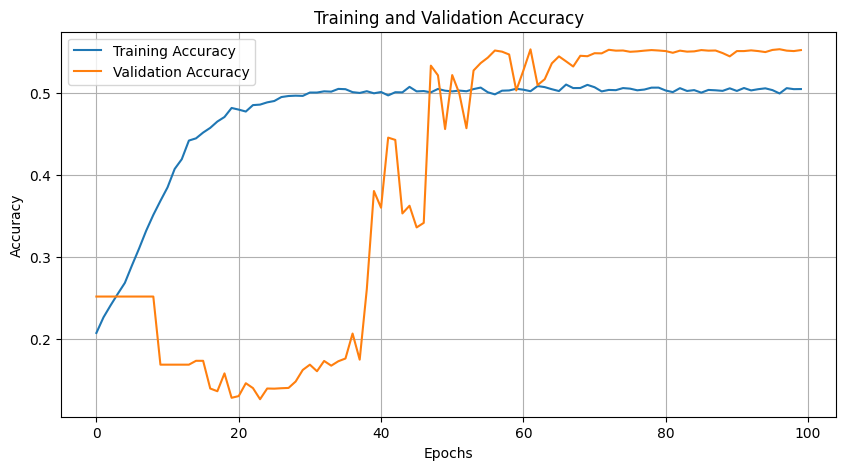

In [9]:
import matplotlib.pyplot as plt 
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))  # Create a new figure for the plot
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Show legend
plt.grid()  # Show grid
plt.show()  # Display the plot